In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
!cp -r '/content/gdrive/My Drive/modeling/lab1/data' .

In [1]:
import pandas as pd
import gc
import os
import numpy as np

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns

from tqdm.notebook import tqdm

np.warnings.filterwarnings('ignore')

In [2]:
CURRENT_DIR = './'  # имя текущей директории для каггл

PATH_TO_TRAIN = CURRENT_DIR + 'data'
# PATH_TO_TEST = CURRENT_DIR + 'input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_test_transactions_contest/test_transactions_contest'

# PATH_TO_TRAIN_TARGET = CURRENT_DIR + 'input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_train_target.csv'
# PATH_TO_TEST_TARGET = CURRENT_DIR + 'input/alfabattle2-sandbox/alfabattle2_sand_alfabattle2_test_target_contest.csv'

PATH_TO_WORKDIR = CURRENT_DIR + 'working/'

In [3]:
def read_parquet_dataset_from_local(path_to_dataset: str, 
                                    start_from: int = 0,
                                    num_parts_to_read: int = 2, 
                                    columns=None, 
                                    verbose=False,
                                    info_num_parts=False) -> pd.DataFrame:
    """
    читает num_parts_to_read партиций, преобразует их к pd.DataFrame и возвращает
    :param path_to_dataset: путь до директории с партициями
    :param start_from: номер партиции, с которой начать чтение
    :param num_parts_to_read: количество партиций, которые требуется прочитать
    :param columns: список колонок, которые нужно прочитать из партиции
    :return: pd.DataFrame
    """

    res = []
    list_paths = sorted([os.path.join(path_to_dataset, filename) for filename in os.listdir(path_to_dataset) 
                              if filename.startswith('part')])
    if info_num_parts:
        print(f'Кол-во партиций в папке: {len(list_paths)}')
    start_from = max(0, start_from)
    list_path_to_partitions = list_paths[start_from: start_from + num_parts_to_read]
    if verbose:
        print('Reading chunks:\n')
        for path_to_partition in list_path_to_partitions:
            print(path_to_partition)
    for path_to_parquet in tqdm(list_path_to_partitions,
                                desc="Читаем файлы:"):
        temp_parquet = pd.read_parquet(path_to_parquet,columns=columns)
        res.append(temp_parquet)
        del temp_parquet
        gc.collect()
    return pd.concat(res).reset_index(drop=True)

In [4]:
columns_to_read = [
    'app_id',
    'amnt',
    'currency',
    'operation_kind',
    'card_type',
    'operation_type',
    'operation_type_group',
    'ecommerce_flag',
    'payment_system',
    'income_flag',
    'mcc',
    'mcc_category',
    'day_of_week',
    'hour',
    'days_before',
    'weekofyear',
    'hour_diff',
    'transaction_number'
]

In [5]:
df = read_parquet_dataset_from_local(PATH_TO_TRAIN, 
                                     start_from=20, 
                                     num_parts_to_read=5,
                                     info_num_parts=True,
                                     columns=columns_to_read)

Кол-во партиций в папке: 49


Читаем файлы::   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
df_2 = read_parquet_dataset_from_local(PATH_TO_TRAIN, 
                                     start_from=25, 
                                     num_parts_to_read=1,
                                     info_num_parts=True,
                                     columns=columns_to_read)

df = pd.concat([df, df_2], ignore_index=True, copy=False).reset_index(drop=True)

Кол-во партиций в папке: 49


Читаем файлы::   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
len(df)

32453755

In [8]:
df[df.amnt == 0.0]

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
1360,434480,0.0,1,6,6,20,3,1,1,1,78,1,5,7,289,19,41,9
1402,434480,0.0,1,1,6,2,1,1,2,1,3,4,6,0,45,34,26,51
3156,434490,0.0,1,1,20,2,1,1,2,1,5,4,3,0,49,24,7,334
3157,434490,0.0,1,1,20,2,1,1,2,1,1,1,1,0,48,24,24,335
3811,434493,0.0,1,1,9,1,1,1,1,1,4,3,3,19,49,24,6,380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32452696,557418,0.0,1,1,52,2,1,1,2,1,1,1,1,0,137,24,15,82
32452697,557418,0.0,1,1,52,2,1,1,2,1,25,6,1,0,137,24,0,83
32452698,557418,0.0,1,1,52,2,1,1,2,1,5,4,1,0,137,24,0,84
32453373,557422,0.0,3,6,42,22,3,2,2,2,62,5,2,0,94,42,41,191


В описании данных написано, что amnt=0.0 это пропуск данных, но присутствуют другие данные, так что тут просто неизвестно, на какую сумму была транзакция.

Берём таких пользователей, у которых больше всего операций

In [9]:
df_users = df.groupby('app_id')['amnt'].count().sort_values()
active_users = df_users.index[-100000:]
active_users

Int64Index([461959, 553594, 435285, 496239, 499691, 531288, 466911, 490413,
            556873, 541328,
            ...
            540010, 452535, 536026, 488608, 513306, 489200, 483880, 525977,
            489520, 490334],
           dtype='int64', name='app_id', length=100000)

In [10]:
df = df[df.app_id.isin(active_users)]
# df = df[df['weekofyear'] != 53]

In [11]:
df.head()

,app_id,amnt,currency,operation_kind,card_type,operation_type,operation_type_group,ecommerce_flag,payment_system,income_flag,mcc,mcc_category,day_of_week,hour,days_before,weekofyear,hour_diff,transaction_number
0,434479,0.570448,1,4,35,4,2,1,3,2,2,2,5,11,359,46,-1,1
1,434479,0.285137,1,1,35,2,1,1,3,1,32,10,5,14,359,46,2,2
2,434479,0.576575,1,1,46,1,1,1,1,1,54,12,5,14,359,46,1,3
3,434479,0.576575,1,1,46,1,1,1,1,1,54,12,5,14,359,46,0,4
4,434479,0.576575,1,1,46,1,1,1,1,1,54,12,5,14,359,46,0,5


In [12]:
df['day_of_year'] = (df['weekofyear'] - 1) * 7 + df['day_of_week'] - 1
df['month'] = (df['day_of_year'] // 31 + 1)

# Профили временной активности

## Суточный

In [78]:
df_hour = pd.pivot_table(df, values='transaction_number', index='app_id', columns='hour',
                         aggfunc='count', fill_value=0)
df_hour_max = df_hour.max(axis=1)
df_hour = df_hour.div(df_hour_max, axis=0)

In [20]:
df_hour.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
app_id,,,,,,,,,,,,,,,,,,,,,
434479,0.081395,0.040698,0.069767,0.040698,0.005814,0.000000,0.017442,0.017442,0.232558,0.453488,...,0.819767,0.755814,0.587209,0.476744,0.534884,0.319767,0.238372,0.197674,0.145349,0.116279
434480,0.500000,0.000000,0.166667,0.166667,0.000000,0.000000,0.166667,0.166667,0.000000,0.500000,...,0.666667,0.833333,0.333333,0.833333,1.000000,1.000000,0.833333,1.000000,0.666667,0.500000
434481,0.000000,0.000000,0.000000,0.000000,0.000000,0.342857,1.000000,0.085714,0.171429,0.114286,...,0.057143,0.085714,0.342857,0.400000,0.257143,0.028571,0.000000,0.000000,0.000000,0.000000
434482,0.655172,0.327586,0.120690,0.068966,0.000000,0.000000,0.017241,0.000000,0.034483,0.103448,...,0.482759,0.620690,0.534483,0.465517,0.379310,0.534483,0.465517,0.620690,0.689655,1.000000
434483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.583333,0.583333,0.083333,...,1.000000,0.250000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Сравнение методов кластеризации

In [22]:
kmeans_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_hour_sample = df_hour.sample(frac=0.1, random_state=0)

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    labels = kmeans.fit_predict(df_hour_sample)

    kmeans_metrics_data['silhouette'].append(silhouette_score(df_hour_sample, labels))
    kmeans_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_hour_sample, labels))
    kmeans_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_hour_sample, labels))

kmeans_metrics_df = pd.DataFrame.from_dict(kmeans_metrics_data, orient='index', columns=list(range(2, 11)))
print('KMeans')
kmeans_metrics_df

KMeans


,2,3,4,5,6,7,8,9,10
silhouette,0.169736,0.129862,0.115462,0.109085,0.104302,0.100640,0.097539,0.093062,0.091838
calinski_harabasz,2225.003857,1742.747543,1502.503503,1319.332875,1177.779732,1074.429439,988.553435,915.204128,856.589412
davies_bouldin,2.066862,2.157104,2.068070,2.127325,2.150403,2.160452,2.199293,2.202445,2.260543


In [23]:
from sklearn.cluster import SpectralClustering

spectral_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_hour_sample = df_hour.sample(frac=0.05, random_state=0)

for i in tqdm(range(2, 11), total=9):
    spectral = SpectralClustering(n_clusters=i, random_state=0)
    labels = spectral.fit_predict(df_hour_sample)

    spectral_metrics_data['silhouette'].append(silhouette_score(df_hour_sample, labels))
    spectral_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_hour_sample, labels))
    spectral_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_hour_sample, labels))

spectral_metrics_df = pd.DataFrame.from_dict(spectral_metrics_data, orient='index', columns=list(range(2, 11)))
print('SpectralClustering')
spectral_metrics_df

  0%|          | 0/9 [00:00<?, ?it/s]

SpectralClustering


,2,3,4,5,6,7,8,9,10
silhouette,0.176814,0.130512,0.117223,0.106160,0.098984,0.089621,0.097290,0.099066,0.094719
calinski_harabasz,1084.519669,857.375147,685.199648,595.413066,513.851675,436.135643,439.022551,402.279926,363.326412
davies_bouldin,2.005248,2.178740,2.051425,2.091533,2.278645,2.524049,2.068655,2.121540,2.256815


In [29]:
# AffinityPropagation

from sklearn.cluster import AffinityPropagation

affin_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_hour_sample = df_hour.sample(frac=0.03, random_state=0)

for i in tqdm(range(2, 10), total=8):
    affin = AffinityPropagation(damping=0.5+i*0.05, random_state=0)
    labels = affin.fit_predict(df_hour_sample)

    if (len(np.unique(labels)) > 1):
        affin_metrics_data['silhouette'].append(silhouette_score(df_hour_sample, labels))
        affin_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_hour_sample, labels))
        affin_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_hour_sample, labels))
    else:
        affin_metrics_data['silhouette'].append(-1)
        affin_metrics_data['calinski_harabasz'].append(-1)
        affin_metrics_data['davies_bouldin'].append(-1)

affin_metrics_df = pd.DataFrame.from_dict(affin_metrics_data, orient='index', columns=list(range(2, 10)))
print('AffinityPropagation')
affin_metrics_df

AffinityPropagation


,2,3,4,5,6,7,8,9
silhouette,0.053832,0.054733,0.053803,0.054215,0.054513,0.053940,0.054494,-1
calinski_harabasz,41.931360,42.386144,41.952327,42.359814,42.153708,42.330431,42.331689,-1
davies_bouldin,2.176216,2.185242,2.174774,2.187606,2.188988,2.195547,2.195240,-1


Последний метод оказался самым плохим по метрикам, kmeans выглядит лучше всего. По метрикам получается лучше всего выбрать число кластеров равным 2.

### Кластеризация

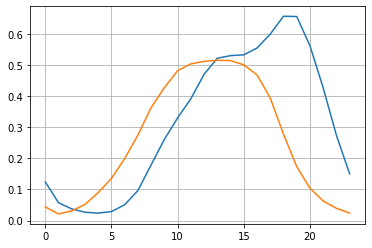

In [79]:
kmeans = KMeans(n_clusters=2, random_state=0)

kmeans.fit(df_hour)

centroids = kmeans.cluster_centers_

for i in range(centroids.shape[0]):
    plt.plot(list(range(centroids.shape[1])), centroids[i])
plt.grid()

**У первого кластера (желтого) видно, что активность постепенно повышается с часа ночи, достигая пика в районе 12 часов, затем плавно убывает.** 

**Второй кластер повышенное количество транзакций в ночь, которое затухает в к 4 часам. Затем с 5 часов снова повышение количества транзакций до пика с 12 до 15 часов, но также есть второй пик в 18 часов. Я предполагаю, что второй пик связан с тем, что люди возвращаются с работы.**

In [80]:
tsne = TSNE(random_state=0, n_jobs=-1)

sample_df_hour = df_hour.sample(frac=0.02, random_state=0)
sample_df_hour_max = df_hour_max.sample(frac=0.02, random_state=0)

X = tsne.fit_transform(sample_df_hour)

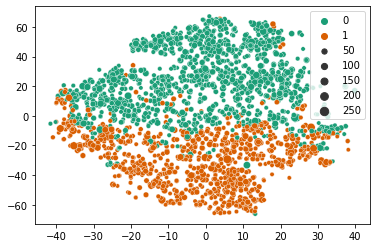

In [81]:
clusters = kmeans.predict(sample_df_hour)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=clusters, palette='Dark2', size=sample_df_hour_max.values)

## Недельный

In [83]:
df_day = pd.pivot_table(df, values='transaction_number', index='app_id', columns='day_of_week',
                         aggfunc='count', fill_value=0)
df_day_max = df_day.max(axis=1)
df_day = df_day.div(df_day.max(axis=1), axis=0)

### Сравнение методов кластеризации

In [84]:
kmeans_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_day_sample = df_day.sample(frac=0.1, random_state=0)

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    labels = kmeans.fit_predict(df_day_sample)

    kmeans_metrics_data['silhouette'].append(silhouette_score(df_day_sample, labels))
    kmeans_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_day_sample, labels))
    kmeans_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_day_sample, labels))

kmeans_metrics_df = pd.DataFrame.from_dict(kmeans_metrics_data, orient='index', columns=list(range(2, 11)))
print('KMeans')
kmeans_metrics_df

KMeans


,2,3,4,5,6,7,8,9,10
silhouette,0.218316,0.207137,0.201514,0.135685,0.127601,0.135731,0.141552,0.142355,0.140088
calinski_harabasz,2360.666884,2250.349094,1862.500127,1639.383154,1495.660859,1386.083100,1299.852785,1224.681296,1163.061519
davies_bouldin,1.993696,1.720434,1.882295,1.888961,1.908366,1.824722,1.782027,1.696466,1.719238


In [85]:
from sklearn.cluster import SpectralClustering

spectral_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_day_sample = df_day.sample(frac=0.05, random_state=0)

for i in tqdm(range(2, 11), total=9):
    spectral = SpectralClustering(n_clusters=i, random_state=0)
    labels = spectral.fit_predict(df_day_sample)

    spectral_metrics_data['silhouette'].append(silhouette_score(df_day_sample, labels))
    spectral_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_day_sample, labels))
    spectral_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_day_sample, labels))

spectral_metrics_df = pd.DataFrame.from_dict(spectral_metrics_data, orient='index', columns=list(range(2, 11)))
print('SpectralClustering')
spectral_metrics_df

  0%|          | 0/9 [00:00<?, ?it/s]

SpectralClustering


,2,3,4,5,6,7,8,9,10
silhouette,0.234145,0.218510,0.202657,0.199757,0.194061,0.191673,0.190298,0.145067,0.127496
calinski_harabasz,1174.027806,1116.081205,882.483636,748.336160,677.293623,611.761287,565.023170,499.061092,490.981407
davies_bouldin,1.991741,1.663798,1.853457,1.821565,1.802458,1.762537,1.687464,1.817856,1.795517


In [86]:
# AffinityPropagation

from sklearn.cluster import AffinityPropagation

affin_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_day_sample = df_day.sample(frac=0.03, random_state=0)

for i in tqdm(range(2, 10), total=8):
    affin = AffinityPropagation(damping=0.5+i*0.05, random_state=0)
    labels = affin.fit_predict(df_day_sample)

    if (len(np.unique(labels)) > 1):
        affin_metrics_data['silhouette'].append(silhouette_score(df_day_sample, labels))
        affin_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_day_sample, labels))
        affin_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_day_sample, labels))
    else:
        affin_metrics_data['silhouette'].append(-1)
        affin_metrics_data['calinski_harabasz'].append(-1)
        affin_metrics_data['davies_bouldin'].append(-1)

affin_metrics_df = pd.DataFrame.from_dict(affin_metrics_data, orient='index', columns=list(range(2, 10)))
print('AffinityPropagation')
affin_metrics_df

  0%|          | 0/8 [00:00<?, ?it/s]

AffinityPropagation


,2,3,4,5,6,7,8,9
silhouette,0.108691,0.111509,0.109824,0.109874,0.110772,0.111499,0.110184,0.110691
calinski_harabasz,82.496129,82.211223,81.737342,82.149909,81.716498,82.275467,82.008580,81.994306
davies_bouldin,1.501399,1.477151,1.491595,1.499459,1.486853,1.480612,1.493885,1.480933


Последний метод оказался самым плохим по метрикам, kmeans выглядит лучше всего. По метрикам получается лучше всего выбрать число кластеров равным 3.

### Кластеризация

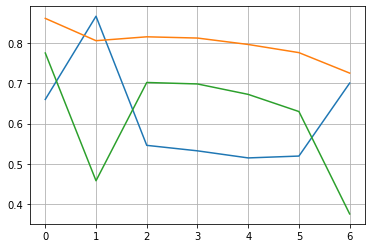

In [87]:
kmeans_day = KMeans(n_clusters=3)

kmeans_day.fit(df_day)

centroids = kmeans_day.cluster_centers_

for i in range(centroids.shape[0]):
    plt.plot(list(range(centroids.shape[1])), centroids[i])
plt.grid()

**Первая группа (желтая) имеет примерно одинаковое количество операций за все дни.**

**Вторая группа (синяя) имеет пик во вторник и в воскресенье. Предполагаю, что люди работают со среды по субботы, в остальные дни отдыхают.**

**Третья группа (зеленая) противоположна второй группе, работают в пн, вторник и воскресенье, в остальные отдыхают.**

In [88]:
tsne = TSNE(random_state=0, n_jobs=-1)

sample_df_day = df_day.sample(frac=0.02, random_state=0)
sample_df_day_max = df_day_max.sample(frac=0.02, random_state=0)

X = tsne.fit_transform(sample_df_day)

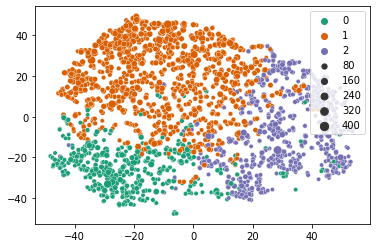

In [89]:
clusters = kmeans_day.predict(sample_df_day)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=clusters, palette='Dark2', size=sample_df_day_max.values)

## Годовой

In [90]:
df_month = pd.pivot_table(df, values='transaction_number', index='app_id', columns='month',
                         aggfunc='count', fill_value=0)
df_month_max = df_month.max(axis=1)
df_month = df_month.div(df_month_max, axis=0)

### Сравнение методов кластеризации

In [91]:
kmeans_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_month_sample = df_month.sample(frac=0.1, random_state=0)

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    labels = kmeans.fit_predict(df_month_sample)

    kmeans_metrics_data['silhouette'].append(silhouette_score(df_month_sample, labels))
    kmeans_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_month_sample, labels))
    kmeans_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_month_sample, labels))

kmeans_metrics_df = pd.DataFrame.from_dict(kmeans_metrics_data, orient='index', columns=list(range(2, 11)))
print('KMeans')
kmeans_metrics_df

KMeans


,2,3,4,5,6,7,8,9,10
silhouette,0.193085,0.166689,0.154995,0.118038,0.106096,0.105750,0.105103,0.097958,0.100394
calinski_harabasz,2569.549155,2003.867018,1640.011561,1390.492693,1222.141380,1108.068323,1009.741873,933.861792,872.624694
davies_bouldin,1.935151,2.090681,2.136153,2.235704,2.356198,2.278219,2.264694,2.258513,2.183271


In [92]:
from sklearn.cluster import SpectralClustering

spectral_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_month_sample = df_month.sample(frac=0.05, random_state=0)

for i in tqdm(range(2, 11), total=9):
    spectral = SpectralClustering(n_clusters=i, random_state=0)
    labels = spectral.fit_predict(df_month_sample)

    spectral_metrics_data['silhouette'].append(silhouette_score(df_month_sample, labels))
    spectral_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_month_sample, labels))
    spectral_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_month_sample, labels))

spectral_metrics_df = pd.DataFrame.from_dict(spectral_metrics_data, orient='index', columns=list(range(2, 11)))
print('SpectralClustering')
spectral_metrics_df

  0%|          | 0/9 [00:00<?, ?it/s]

SpectralClustering


,2,3,4,5,6,7,8,9,10
silhouette,0.197362,0.170434,0.156360,0.144861,0.119678,0.111671,0.105001,0.105115,0.106231
calinski_harabasz,1257.329786,979.191758,797.426404,660.947279,559.269891,495.655020,450.423523,410.020254,373.915796
davies_bouldin,1.943353,2.028843,1.978911,2.133845,2.112857,2.173038,2.195644,2.137113,2.133885


In [93]:
# AffinityPropagation

from sklearn.cluster import AffinityPropagation

affin_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_month_sample = df_month.sample(frac=0.03, random_state=0)

for i in tqdm(range(2, 10), total=8):
    affin = AffinityPropagation(damping=0.5+i*0.05, random_state=0)
    labels = affin.fit_predict(df_month_sample)

    if (len(np.unique(labels)) > 1):
        affin_metrics_data['silhouette'].append(silhouette_score(df_month_sample, labels))
        affin_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_month_sample, labels))
        affin_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_month_sample, labels))
    else:
        affin_metrics_data['silhouette'].append(-1)
        affin_metrics_data['calinski_harabasz'].append(-1)
        affin_metrics_data['davies_bouldin'].append(-1)

affin_metrics_df = pd.DataFrame.from_dict(affin_metrics_data, orient='index', columns=list(range(2, 10)))
print('AffinityPropagation')
affin_metrics_df

  0%|          | 0/8 [00:00<?, ?it/s]

AffinityPropagation


,2,3,4,5,6,7,8,9
silhouette,-1,0.056614,0.056541,0.056864,0.056100,0.055916,0.056551,-1
calinski_harabasz,-1,43.417478,44.030246,43.903793,44.263825,43.748771,43.908417,-1
davies_bouldin,-1,1.986769,2.004880,2.006031,2.005161,2.002978,2.005060,-1


Последний метод оказался самым плохим по метрикам, kmeans выглядит лучше всего. По метрикам получается лучше всего выбрать число кластеров равным 2.

### Кластеризация

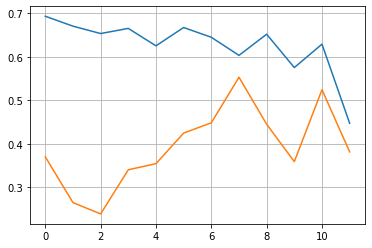

In [94]:
kmeans_month = KMeans(n_clusters=2)

kmeans_month.fit(df_month)

centroids = kmeans_month.cluster_centers_

for i in range(centroids.shape[0]):
    plt.plot(list(range(centroids.shape[1])), centroids[i])
plt.grid()

**Первая группа (синяя) имеет с января по ноябрь примерно одинаковое количество операций, а вот в декабре сильно низкие. Возможно, это из-за того, что люди уезжают куда-то в это время либо количество операций ниже (но сумма транзакций выше, что мы на этом графике не видим)**

In [95]:
tsne = TSNE(random_state=0, n_jobs=-1)

sample_df_month = df_month.sample(frac=0.02, random_state=0)
sample_df_month_max = df_month_max.sample(frac=0.02, random_state=0)

X = tsne.fit_transform(sample_df_month)

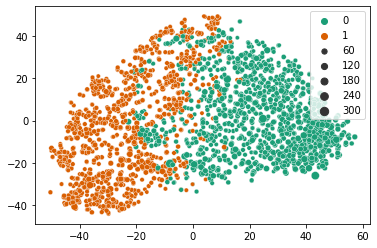

In [96]:
clusters = kmeans_month.predict(sample_df_month)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=clusters, palette='Dark2', size=sample_df_month_max.values)

# Профили по тратам

In [60]:
df[df.income_flag == 1].mcc_category.value_counts()

1     9189254
4     3865838
3     3692339
2     3622509
5     1890496
6     1546961
7     1300905
9      851946
11     520733
12     506062
10     497329
14     369961
13     348488
8      283721
15     265041
16     148295
17     145221
18     135066
19     120148
21     105740
22      98887
20      89862
23      53605
24      42921
25      29225
26      23628
27      18393
28        509
Name: mcc_category, dtype: int64

In [61]:
df[df.income_flag == 1].mcc.value_counts()

1      7986101
2      2849436
3      2484675
4      2017051
5      1381163
        ...   
107      11296
106      11014
105       6642
91        5306
11          10
Name: mcc, Length: 108, dtype: int64

In [65]:
df[df.income_flag == 1].operation_kind.value_counts()

1    25879686
2     2837697
3      911517
6      117007
7       13910
5        3266
Name: operation_kind, dtype: int64

In [68]:
df[df.income_flag == 1].payment_system.value_counts()

3    20383160
1     5201462
2     3300814
4      783182
6       59725
5       34740
Name: payment_system, dtype: int64

Посмотрим квантили трат относительно платежной системы

In [13]:
df['amnt_bin'] = (df['amnt'] * 10).astype(int)

In [14]:
df['amnt_bin'].value_counts()

3    13701765
2     8422498
4     6338950
5     2221904
1      674305
6      509663
0      151122
7       35249
8         115
9           6
Name: amnt_bin, dtype: int64

In [17]:
df_ps = pd.pivot_table(df[df.income_flag == 1], values='amnt', index='app_id', columns='payment_system',
                         aggfunc='sum', fill_value=0)
df_ps_max = df_ps.max(axis=1)
df_ps = df_ps.div(df_ps_max, axis=0)

### Сравнение методов кластеризации

In [30]:
kmeans_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_ps_sample = df_ps.sample(frac=0.1, random_state=0)

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    labels = kmeans.fit_predict(df_ps_sample)

    kmeans_metrics_data['silhouette'].append(silhouette_score(df_ps_sample, labels))
    kmeans_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_ps_sample, labels))
    kmeans_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_ps_sample, labels))

kmeans_metrics_df = pd.DataFrame.from_dict(kmeans_metrics_data, orient='index', columns=list(range(2, 11)))
print('KMeans')
kmeans_metrics_df

KMeans


,2,3,4,5,6,7,8,9,10
silhouette,0.537120,0.546218,0.452596,0.417674,0.410258,0.402885,0.372566,0.383377,0.387666
calinski_harabasz,7203.850109,8725.727051,8623.637501,8530.009112,8791.919450,8685.598287,8401.663048,8080.167410,7930.748070
davies_bouldin,0.844988,0.760068,0.783223,0.812657,0.814731,0.832793,0.872430,0.832101,0.812509


In [31]:
from sklearn.cluster import SpectralClustering

spectral_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_ps_sample = df_ps.sample(frac=0.05, random_state=0)

for i in tqdm(range(2, 11), total=9):
    spectral = SpectralClustering(n_clusters=i, random_state=0)
    labels = spectral.fit_predict(df_ps_sample)

    spectral_metrics_data['silhouette'].append(silhouette_score(df_ps_sample, labels))
    spectral_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_ps_sample, labels))
    spectral_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_ps_sample, labels))

spectral_metrics_df = pd.DataFrame.from_dict(spectral_metrics_data, orient='index', columns=list(range(2, 11)))
print('SpectralClustering')
spectral_metrics_df

  0%|          | 0/9 [00:00<?, ?it/s]

SpectralClustering


,2,3,4,5,6,7,8,9,10
silhouette,0.571375,0.573501,0.521889,0.503780,0.503778,0.385530,0.371345,0.390637,0.391976
calinski_harabasz,3343.587457,3442.428674,3534.097873,3410.576613,2888.966993,2944.990816,2358.280661,2964.514106,2778.577267
davies_bouldin,0.719831,0.663532,0.695477,0.699253,0.869674,0.885215,0.956358,0.875256,0.842934


In [32]:
# AffinityPropagation

from sklearn.cluster import AffinityPropagation

affin_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_ps_sample = df_ps.sample(frac=0.03, random_state=0)

for i in tqdm(range(2, 10), total=8):
    affin = AffinityPropagation(damping=0.5+i*0.05, random_state=0)
    labels = affin.fit_predict(df_ps_sample)

    if (len(np.unique(labels)) > 1):
        affin_metrics_data['silhouette'].append(silhouette_score(df_ps_sample, labels))
        affin_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_ps_sample, labels))
        affin_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_ps_sample, labels))
    else:
        affin_metrics_data['silhouette'].append(-1)
        affin_metrics_data['calinski_harabasz'].append(-1)
        affin_metrics_data['davies_bouldin'].append(-1)

affin_metrics_df = pd.DataFrame.from_dict(affin_metrics_data, orient='index', columns=list(range(2, 10)))
print('AffinityPropagation')
affin_metrics_df

  0%|          | 0/8 [00:00<?, ?it/s]

AffinityPropagation


,2,3,4,5,6,7,8,9
silhouette,-1,-1,0.310302,0.316883,0.304242,0.303746,0.301357,0.467464
calinski_harabasz,-1,-1,1754.889758,1747.736536,1773.288961,1766.512299,1767.424821,1876.598426
davies_bouldin,-1,-1,0.846618,0.835145,0.846088,0.850464,0.840590,0.737425


Последний метод оказался самым плохим по метрикам, kmeans выглядит лучше всего. В качестве параметра внутреннее чутье подсказывает выбрать значение 3.

### Кластеризация

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)

kmeans.fit(df_ps)

clusters = kmeans.predict(df_ps)

(array([4.55486831e-02, 2.27283961e-01, 2.97104042e+00, 4.48335694e+00,
        1.72069322e+00, 4.59573194e-01, 8.79473158e-02, 4.52493413e-03,
        3.13264670e-05, 0.00000000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

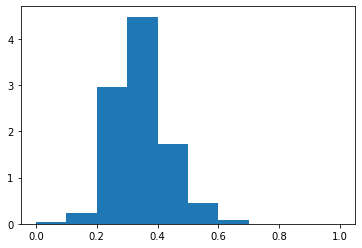

In [56]:
idxs = df_ps.index[np.argwhere(clusters == 0).reshape(-1)]
ops = df.loc[(df.app_id.isin(idxs)) & (df.income_flag == 1), 'amnt']
plt.figure()
plt.hist(ops, bins=10, range=(0, 1), density=True)

(array([4.63128069e-02, 2.10902195e-01, 2.70323384e+00, 4.48436517e+00,
        1.89682754e+00, 5.40124659e-01, 1.10814285e-01, 7.37852082e-03,
        3.82843529e-05, 2.70242491e-06]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

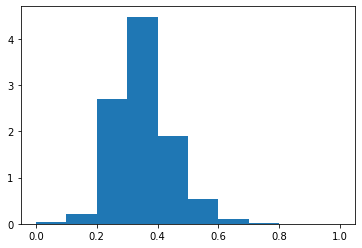

In [57]:
idxs = df_ps.index[np.argwhere(clusters == 1).reshape(-1)]
ops = df.loc[(df.app_id.isin(idxs)) & (df.income_flag == 1), 'amnt']
plt.figure()
plt.hist(ops, bins=10, range=(0, 1), density=True)

(array([5.49038564e-02, 2.80368469e-01, 3.08406169e+00, 4.38272625e+00,
        1.68209562e+00, 4.20495107e-01, 8.87553327e-02, 6.55313726e-03,
        4.05304713e-05, 0.00000000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

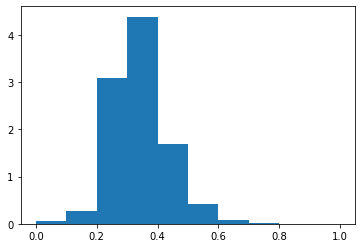

In [58]:
idxs = df_ps.index[np.argwhere(clusters == 2).reshape(-1)]
ops = df.loc[(df.app_id.isin(idxs)) & (df.income_flag == 1), 'amnt']
plt.figure()
plt.hist(ops, bins=10, range=(0, 1), density=True)

**Исходя из кластеризации по разным платежным системам клиенты практически не отличаются. Больше всего трат 0.2, 0.3 и 0.4, остальных трат почти нет.**

In [28]:
tsne = TSNE(random_state=0, n_jobs=-1)

sample_df_ps = df_ps.sample(frac=0.02, random_state=0)
sample_df_ps_max = df_ps_max.sample(frac=0.02, random_state=0)

X = tsne.fit_transform(sample_df_ps)

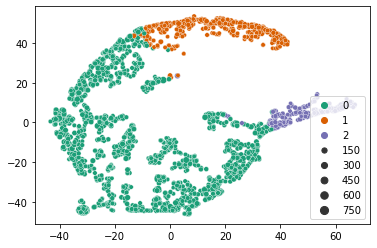

In [29]:
clusters = kmeans.predict(sample_df_ps)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=clusters, palette='Dark2', size=sample_df_ps_max.values)

# Профили интересов

In [61]:
df.mcc.unique(), df.mcc.nunique()

(array([  2,  32,  54,  43,   8,   1,  10,  18,   7,   3,  24,   4,  39,
          5,  53, 106,  11,  46,  26,  72,  33,  17,  84,  21,  14,  47,
         48,  35,  37,  15, 103, 108,  22,  57,  38,  34,   9,  87,  80,
         45,  28,  59,  16,  68,  31,  62,  89, 104,  75,  67,  64,  66,
         30,  13,  20,  82,  79,  88,  55,  19,  63,  25,  12,  27,  78,
         56,  40, 101,  50,  60, 100, 102, 107,  81,   6,  94,  41,  99,
         49,  69,  65,  92,  83,  86,  77,  61,  58,  71,  29,  93,  44,
         74,  42,  70,  73,  85,  51,  95,  36,  23,  52,  97,  98,  76,
         91,  96, 105,  90], dtype=int32), 108)

In [62]:
df.mcc_category.unique(), df.mcc_category.nunique()

(array([ 2, 10, 12, 22,  1,  7,  6,  5,  4,  3, 21,  8, 20, 14, 15, 13,  9,
        18, 11, 16, 19, 17, 26, 27, 24, 23, 25, 28], dtype=int32), 28)

Столбцы mcc и mcc category не соотносятся с реальными mcc кодами, следовательно они зашифрованы, вытащить интересы клиентов не получится. Можно кластеризовать по mcc_category и посмотреть в каких категориях больше всего трат для каждого кластера.

In [63]:
df_mcc_cat = pd.pivot_table(df[df.income_flag == 1], values='transaction_number', index='app_id', columns='mcc_category',
                         aggfunc='count', fill_value=0)
df_mcc_cat_max = df_mcc_cat.max(axis=1)
df_mcc_cat = df_mcc_cat.div(df_mcc_cat_max, axis=0)

### Сравнение методов кластеризации

In [64]:
kmeans_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_mcc_cat_sample = df_mcc_cat.sample(frac=0.1, random_state=0)

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    labels = kmeans.fit_predict(df_mcc_cat_sample)

    kmeans_metrics_data['silhouette'].append(silhouette_score(df_mcc_cat_sample, labels))
    kmeans_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_mcc_cat_sample, labels))
    kmeans_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_mcc_cat_sample, labels))

kmeans_metrics_df = pd.DataFrame.from_dict(kmeans_metrics_data, orient='index', columns=list(range(2, 11)))
print('KMeans')
kmeans_metrics_df

KMeans


,2,3,4,5,6,7,8,9,10
silhouette,0.224400,0.230644,0.254598,0.264580,0.232883,0.241512,0.237351,0.240265,0.224572
calinski_harabasz,1985.397760,2034.233045,2001.106060,1831.692479,1714.381214,1575.628439,1462.964280,1371.503538,1301.972958
davies_bouldin,1.867571,1.801227,1.490334,1.499147,1.488240,1.640859,1.691318,1.620614,1.631600


In [65]:
from sklearn.cluster import SpectralClustering

spectral_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_mcc_cat_sample = df_mcc_cat.sample(frac=0.05, random_state=0)

for i in tqdm(range(2, 11), total=9):
    spectral = SpectralClustering(n_clusters=i, random_state=0)
    labels = spectral.fit_predict(df_mcc_cat_sample)

    spectral_metrics_data['silhouette'].append(silhouette_score(df_mcc_cat_sample, labels))
    spectral_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_mcc_cat_sample, labels))
    spectral_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_mcc_cat_sample, labels))

spectral_metrics_df = pd.DataFrame.from_dict(spectral_metrics_data, orient='index', columns=list(range(2, 11)))
print('SpectralClustering')
spectral_metrics_df

  0%|          | 0/9 [00:00<?, ?it/s]

SpectralClustering


,2,3,4,5,6,7,8,9,10
silhouette,0.232602,0.236193,0.257523,0.235025,0.244360,0.246297,0.233609,0.233932,0.221667
calinski_harabasz,929.304521,984.258814,960.135496,849.836505,816.732768,736.436795,667.594919,633.935521,587.298499
davies_bouldin,1.606007,1.813297,1.483391,1.602561,1.507087,1.710131,1.619518,1.534268,1.536112


In [66]:
# AffinityPropagation

from sklearn.cluster import AffinityPropagation

affin_metrics_data = {
    'silhouette': [],
    'calinski_harabasz': [],
    'davies_bouldin': []
}

df_mcc_cat_sample = df_mcc_cat.sample(frac=0.03, random_state=0)

for i in tqdm(range(2, 10), total=8):
    affin = AffinityPropagation(damping=0.5+i*0.05, random_state=0)
    labels = affin.fit_predict(df_mcc_cat_sample)

    if (len(np.unique(labels)) > 1):
        affin_metrics_data['silhouette'].append(silhouette_score(df_mcc_cat_sample, labels))
        affin_metrics_data['calinski_harabasz'].append(calinski_harabasz_score(df_mcc_cat_sample, labels))
        affin_metrics_data['davies_bouldin'].append(davies_bouldin_score(df_mcc_cat_sample, labels))
    else:
        affin_metrics_data['silhouette'].append(-1)
        affin_metrics_data['calinski_harabasz'].append(-1)
        affin_metrics_data['davies_bouldin'].append(-1)

affin_metrics_df = pd.DataFrame.from_dict(affin_metrics_data, orient='index', columns=list(range(2, 10)))
print('AffinityPropagation')
affin_metrics_df

  0%|          | 0/8 [00:00<?, ?it/s]

AffinityPropagation


,2,3,4,5,6,7,8,9
silhouette,0.094725,0.094133,0.096285,0.104178,0.100119,0.100036,0.098042,0.096871
calinski_harabasz,89.858959,89.234089,89.053123,90.057105,89.754689,89.793859,88.964557,89.530796
davies_bouldin,1.547016,1.575591,1.581845,1.556320,1.551793,1.550085,1.551738,1.587289


Выбираю KMeans с числом кластеров 4

### Кластеризация

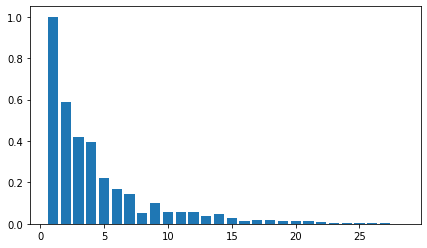

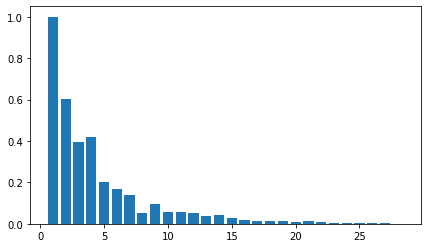

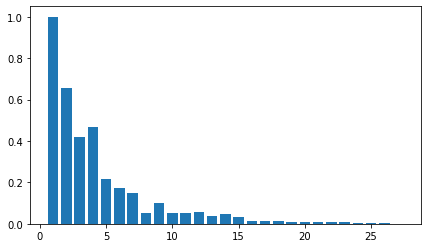

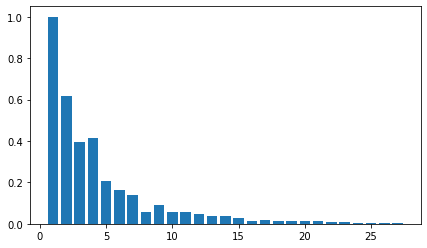

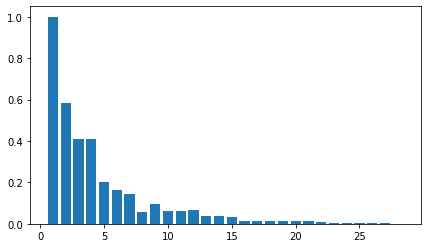

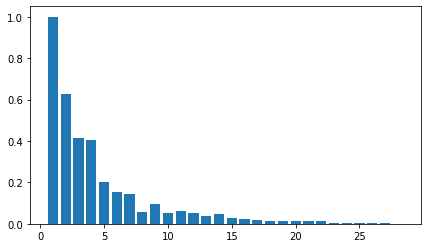

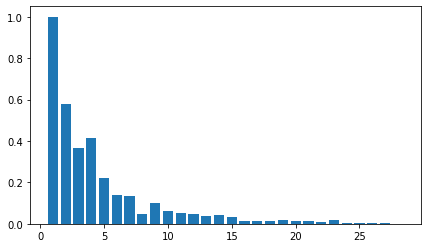

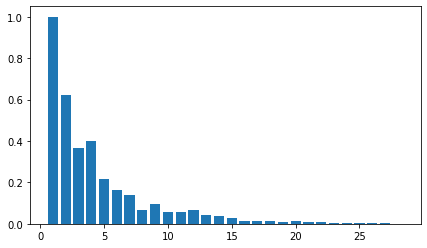

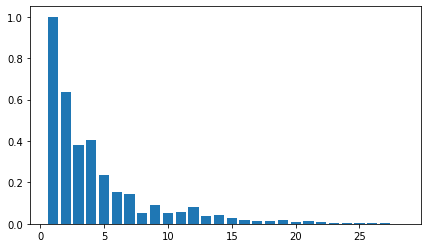

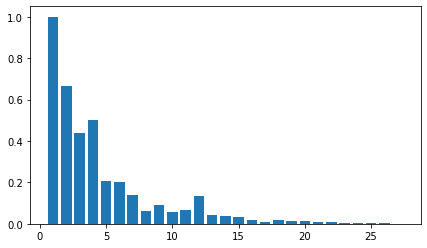

In [76]:
clusters = kmeans.labels_
uniq_clusters = np.unique(clusters)

for i in uniq_clusters:
    idxs = df_ps.index[np.argwhere(clusters == i).reshape(-1)]
    ops = df.loc[df.app_id.isin(idxs), 'mcc_category'].value_counts()
    ops /= ops.max()
    plt.figure(figsize=(7, 4))
    plt.bar(ops.index, ops)

**В целом все кластера одинаковые, но у 4 кластера наблюдается увеличенное внимание к 12 категории и пониженное к 5 категории.**